# Hybrid Model For Covid-19 Infection Predictions
## This model uses a SIR model variant to calculate model parameters associated with an intervention such as lockdown. Then, aspects of an LSTM model are combined with the benefits of a SIR model.
#### Rebecca Davidsson - 02/2021

In [1]:
import os
os.chdir("../LSTM")

In [2]:
from core.nn.LSTMmodel import LSTM

%load_ext autoreload
%autoreload 2

import pickle
import datetime
from numpy import array
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import requests, io, json, urllib
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from itertools import cycle
import seaborn as sns
sns.set()
%matplotlib inline

## Load timeseries data

In [3]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


In [936]:
# Select country of interest (using ISO 3166-1 alpha-3 country code)
COUNTRY = "Switzerland"

## Load governmental policy data (Non-pharmaceutical Interventions, or NPIs)

In [937]:
def get_periods(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))
    
    
TARGET = "Stringency_index"
NPI_df = oxcgrt_data.cleaned()
NPI_df = NPI_df[NPI_df["Country"] == COUNTRY]

# Get lockdown dates
NPI_df = NPI_df.reset_index().drop('index', axis=1)
NPI_df = NPI_df.groupby("Date").mean().reset_index()
lockdown_indexes = NPI_df[NPI_df[TARGET] >= 75].index
lockdown_dates = NPI_df[NPI_df[TARGET] >= 75]["Date"]
periods = get_periods(lockdown_indexes)

fig = px.line(NPI_df, x="Date", y=TARGET, title='Lockdown periods in ' + COUNTRY)
for dates in periods:
    fig.add_vrect(x0=NPI_df.iloc[dates[0]]["Date"], x1=NPI_df.iloc[dates[1]]["Date"], line_width=0, fillcolor="red", opacity=0.2)
fig.show()

## Calculate delay days for this country

In [938]:
s = cs.Scenario(jhu_data, population_data, country=COUNTRY)
days_delay, df_periods = s.estimate_delay(oxcgrt_data)
print(f'Delay days: {days_delay}')
days_delay = 26

Delay days: 15


## Adjust data for delay days

In [907]:
lockdown_dates_adjusted = []
for date in lockdown_dates:
    new_date = date + datetime.timedelta(days = days_delay)
    lockdown_dates_adjusted.append(new_date)
lockdown_dates_adjusted = pd.Series(lockdown_dates_adjusted) 

# Save variable DELAY_START, which is equal to the start of a lockdown period
# in this case, we will hardcode the script to the second lockdown date
DELAY_START = NPI_df.iloc[periods[1][0]].Date


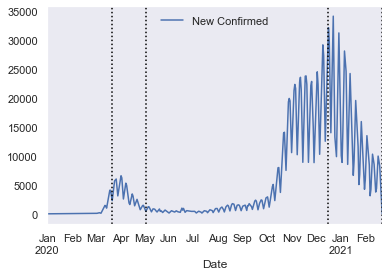

In [908]:
df = jhu_data.cleaned()
df = df[(df["Country"] == COUNTRY) & (df["Province"] == "-")]
df["New Confirmed"] = df["Confirmed"].diff()
df.plot(x="Date", y="New Confirmed");
for dates in periods:
    plt.axvline(x=NPI_df.iloc[dates[0]]["Date"], color="black", linestyle=":");
    plt.axvline(x=NPI_df.iloc[dates[1]]["Date"], color="black", linestyle=":");
plt.show()

## Load model parameters over time

In [935]:
df_params = pd.read_pickle("../figures/pickles/df_14_countries.p")
df_params

,Date,Country,Rt,theta,kappa,rho,sigma,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
0,2020-03-03,Switzerland,117.92,0.034049,0.000302,0.047025,0.000083,0,0,2,1,0,0,0,0,2,2,1,25.00
1,2020-03-03,Switzerland,117.92,0.034049,0.000302,0.047025,0.000083,0,0,2,1,0,0,0,0,2,2,1,25.00
2,2020-03-03,Switzerland,117.92,0.034049,0.000302,0.047025,0.000083,0,0,2,1,0,0,0,0,2,2,1,25.00
3,2020-03-03,Switzerland,117.92,0.034049,0.000302,0.047025,0.000083,0,0,2,1,0,0,0,0,2,2,1,25.00
4,2020-03-03,Switzerland,117.92,0.034049,0.000302,0.047025,0.000083,0,0,2,1,0,0,0,0,2,2,1,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55658,2021-01-10,Canada,0.87,0.003232,0.000309,0.022474,0.025305,3,2,0,3,0,1,0,3,2,3,1,64.35
55659,2021-01-10,Canada,0.87,0.003232,0.000309,0.022474,0.025305,3,2,0,3,0,1,0,3,2,3,1,64.35
55660,2021-01-10,Canada,0.87,0.003232,0.000309,0.022474,0.025305,3,2,0,3,0,1,0,3,2,3,1,64.35
55661,2021-01-10,Canada,0.87,0.003232,0.000309,0.022474,0.025305,3,2,0,3,0,1,0,3,2,3,1,64.35


In [932]:

df_params = df_params[df_params["Country"] == COUNTRY]

def plot_param(df, periods, TARGET):
    fig = px.line(df, x="Date", y=TARGET, title='Lockdown periods in the Netherlands')
    for dates in periods:
        fig.add_vrect(x0=NPI_df.iloc[dates[0]]["Date"], x1=NPI_df.iloc[dates[1]]["Date"], line_width=0, fillcolor="red", opacity=0.2)
    fig.show()
    
plot_param(df_params, periods, TARGET="Rt")

KeyError: 'Country'

## Calculate model parameters for given intervention

#### In this case, we will calculate the parameters associated with the lockdown
#### NOTE: The DELAY is also included in the calculations by using the variable `lockdown_dates_adjusted`!

In [910]:
def calc_param(df, lockdown_dates):
    total_params = ["theta", "kappa", "rho", "sigma", "1/gamma [day]", "alpha1 [-]",  "1/alpha2 [day]", "1/beta [day]"]
    calc_params_df = {}
    for param in total_params:
        values = []
        for date in df["Date"].values:
            if date in lockdown_dates.values:
                values.append(np.mean(df[df['Date'] == date][param]))
        calc_params_df[param] = np.mean(values)
    return calc_params_df

params = calc_param(df_params, lockdown_dates_adjusted)
params

{'theta': 0.08518032828516765,
 'kappa': 5.792020068469921e-05,
 'rho': 0.017836589313111426,
 'sigma': 0.026825539260029153,
 '1/gamma [day]': 8.906976744186046,
 'alpha1 [-]': 0.08506976744186046,
 '1/alpha2 [day]': 4423.232558139535,
 '1/beta [day]': 13.813953488372093}

### These calculated parameters are associated with a lockdown and can be used to predict future scenarios for the same type of intervention. Here we simulate this scenario using the SIR model. This can take up to 5 minutes.

In [911]:
TRAIN_UP_TO  = DELAY_START 

country_df = jhu_data.cleaned()
country_df = country_df[(country_df["Country"] == COUNTRY) & (country_df["Province"] == "-") ]
selection = country_df[country_df["Date"] == DELAY_START + datetime.timedelta(days_delay + 2)]

selection["Confirmed"] = abs(selection2["Confirmed"].values[0] - selection["Confirmed"].values[0])
population_df = population_data.cleaned()
N = population_df[population_df["Country"] == COUNTRY]["Population"].values[0]
selection.head()


,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
19652,2021-01-13,Germany,-,24160,198,57711,1933694


In [912]:
from SIR_ODE import SIR
sir = SIR(N=N, I0=selection["Confirmed"].values[0], R0=selection["Recovered"].values[0], 
          beta=params["rho"], gamma=params["theta"],
         days=85)

82905782 24160 1933694 80947928 0.017836589313111426 0.08518032828516765


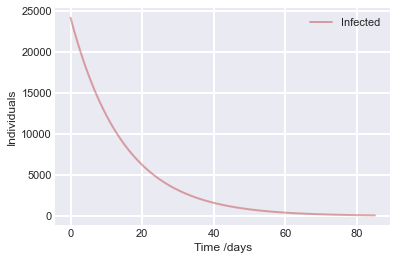

In [913]:
sns.set_style(style='dark')
SIR_results = sir.simulate(target="Infected")

## Run LSTM model

In [914]:
DEVICE       = 'cpu'
ThreshConf   = 70
ThreshDead   = 20
TARGET       = "New Confirmed"
# FUTURE_DAYS  = 30
# DELAY_START  = TRAIN_UP_TO + datetime.timedelta(days=days_delay)
TYPE         = "LSTMCell"

### Results serve as input for new predictions

## Add SIR-predictions as bias to LSTM model

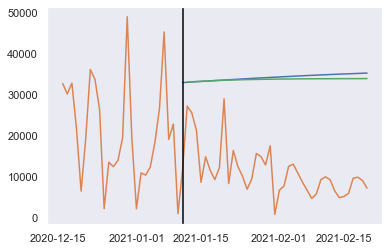

In [926]:
def add_bias(results, BIAS):
    data = results.copy()
    preds = []
    SIR_data = []
    dates = []
    BIAS_START = DELAY_START + datetime.timedelta(days_delay)
    for date, pred, index in zip(data["valData"]["Date"], data["pred"], range(0, len(data["valData"]))):
        if date >= BIAS_START:
            preds.append(pred)
            dates.append(date)
            SIR_data.append(SIR_results["I"][index])
    plt.plot(dates, preds)
    plt.plot(data["valData"]["Date"], data["valData"]["ConfirmedCases"])
#     plt.plot(np.array(results1["valData"]["Date"].values)[0:FUTURE_DAYS:], data["pred"])
    plt.axvline(BIAS_START, color="black")

        
    # Add bias to prediction
    # Calculate trend in SIR-predictions
    x = np.arange(0,len(SIR_data))
    y = np.array(SIR_data)
    z = np.polyfit(x, y, 1)[0]

    new_preds, old_preds = [], []
    weight = 0.2
    for i in range(len(preds) - 1):
        diff = preds[i + 1] - preds[i]
#         y = z *i-days_delay**2+2*i-days_delay+2
        percent = (i+1) / len(preds)
        if i >= days_delay / 2:
            weight -= 0.005
        new_trend = (percent * z * i**(index/(min(preds)) + weight) + diff)
        new_trend = new_trend + diff
        new_preds.append(preds[i] + new_trend)
        old_preds.append(preds[i])
    plt.plot(dates[1:], new_preds)
    plt.show()
#     new_preds, old_preds = [], []
#     for i in range(len(preds) - 1):
#         diff = abs(preds[i + 1] - preds[i])
#     #     y = (-(i - days_delay)**2) / 500
#         weight = i * 0.02**(1+ i/z)
#         new_trend = z * weight * diff + preds[0]
#         new_preds.append(new_trend)
#         old_preds.append(preds[i])
#     plt.plot(dates[1:], new_preds)
#     plt.show()
               
    # Add data to results
    data["total_old_pred"] = data["pred"]
    data["pred"] = new_preds
    data["oldpred"] = old_preds
    return data
add_bias(results1, BIAS);

In [930]:
index

58

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


 17%|█▋        | 1/6 [00:03<00:18,  3.65s/it, Loss =0.287, Lr=0.01]

tensor(67.5824, grad_fn=<AddBackward0>)



  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7



100%|██████████| 6/6 [00:14<00:00,  2.34s/it, Loss =0.0208, Lr=0.01]


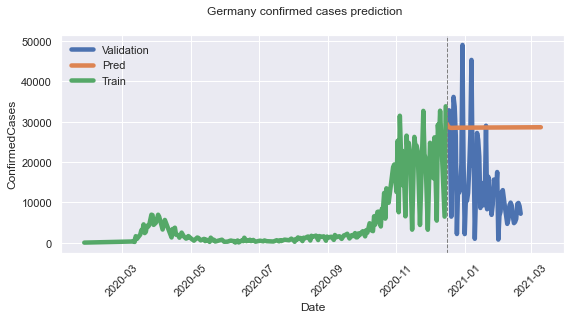

 17%|█▋        | 1/6 [00:23<01:55, 23.09s/it, Loss =0.287, Lr=0.01]

RMSLE : 0.52050  (not normalized)


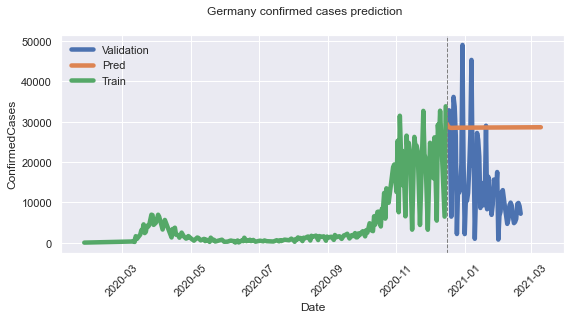

RMSLE : 0.52050  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:14<00:00,  2.44s/it, Loss =0.0208, Lr=0.01]


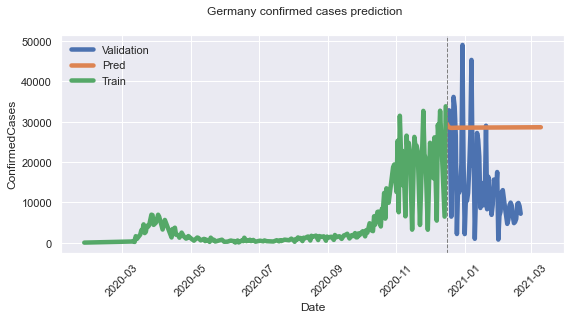

RMSLE : 0.61661  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:14<00:00,  2.41s/it, Loss =0.0212, Lr=0.01]


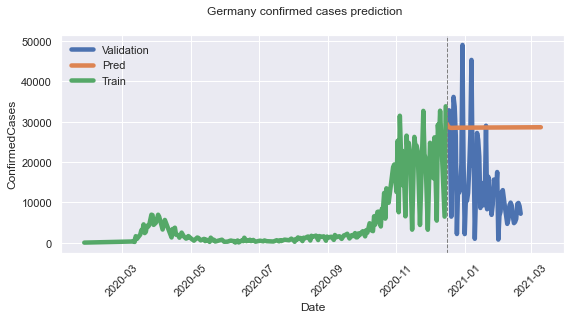

RMSLE : 0.53048  (not normalized)


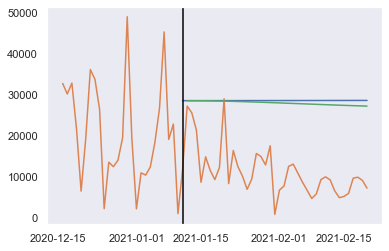

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:13<00:00,  2.33s/it, Loss =0.0202, Lr=0.01]


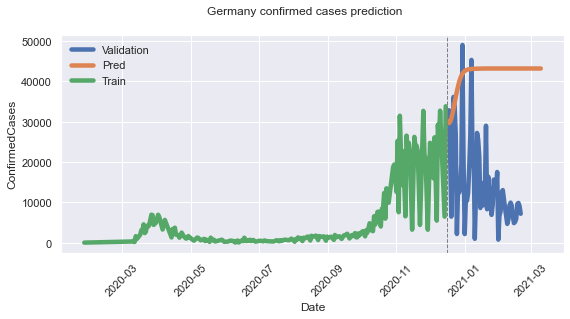

RMSLE : 0.64982  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:13<00:00,  2.19s/it, Loss =0.0227, Lr=0.01]


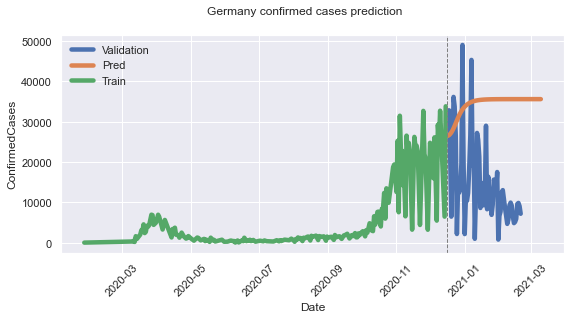

RMSLE : 0.57931  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:03<00:00,  1.56it/s, Loss =3.5, Lr=0.01]  


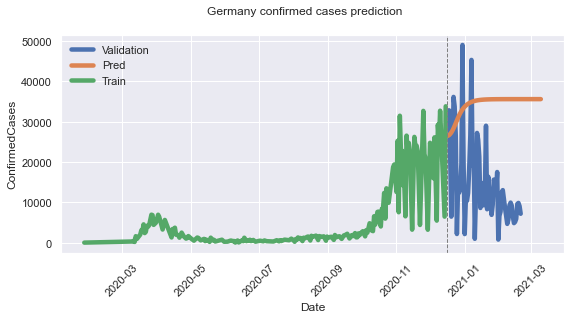

RMSLE : 0.62973  (not normalized)


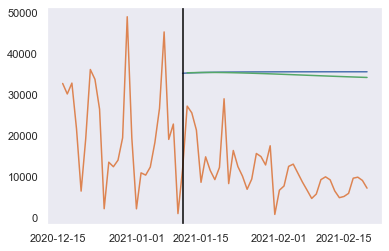

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:12<00:00,  2.15s/it, Loss =0.0197, Lr=0.01]


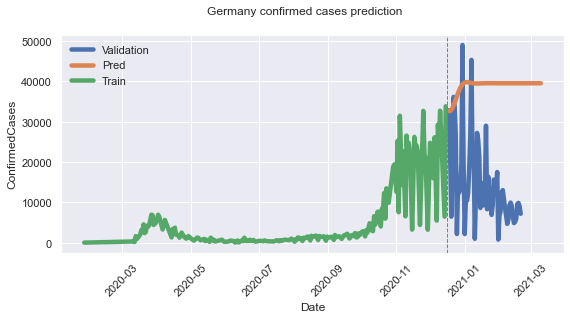

RMSLE : 0.62489  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


 17%|█▋        | 1/6 [00:01<00:09,  1.85s/it, Loss =0.567, Lr=0.01]

tensor(114.0558, grad_fn=<AddBackward0>)



  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7



100%|██████████| 6/6 [00:11<00:00,  1.97s/it, Loss =0.0255, Lr=0.01]


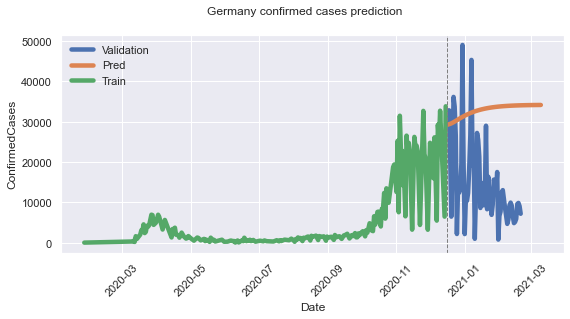

 17%|█▋        | 1/6 [00:16<01:21, 16.38s/it, Loss =0.567, Lr=0.01]

RMSLE : 0.56456  (not normalized)


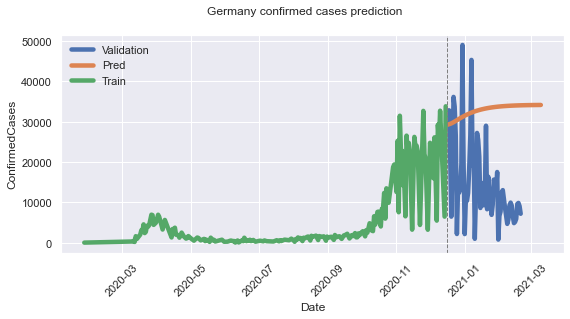

RMSLE : 0.56456  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:14<00:00,  2.44s/it, Loss =0.0198, Lr=0.01]


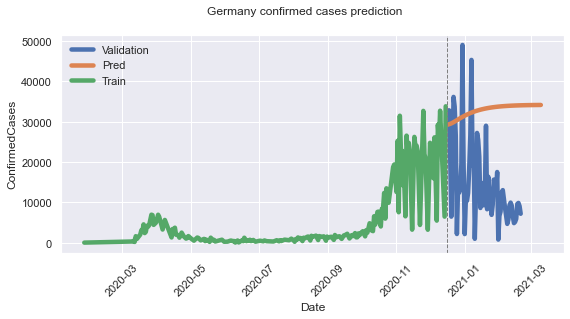

RMSLE : 0.60374  (not normalized)


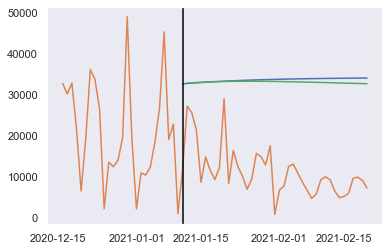

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:12<00:00,  2.14s/it, Loss =0.0253, Lr=0.01]


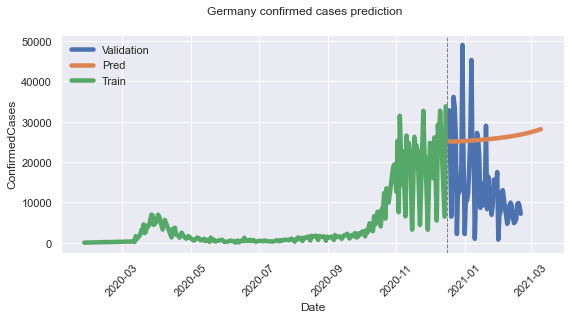

RMSLE : 0.48652  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:13<00:00,  2.19s/it, Loss =0.02, Lr=0.01]  


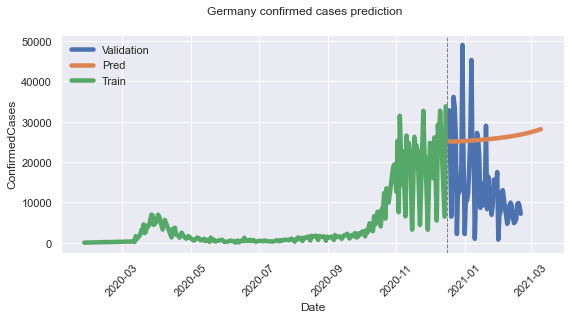

RMSLE : 0.69850  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


 33%|███▎      | 2/6 [00:03<00:07,  1.84s/it, Loss =0.297, Lr=0.01]

tensor(44.8619, grad_fn=<AddBackward0>)



  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7



100%|██████████| 6/6 [00:15<00:00,  2.53s/it, Loss =0.0203, Lr=0.01]


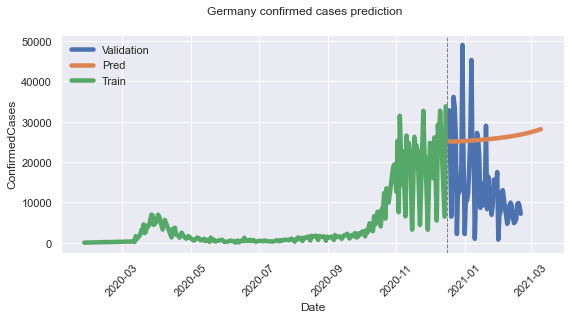

 33%|███▎      | 2/6 [00:22<00:45, 11.45s/it, Loss =0.297, Lr=0.01]

RMSLE : 0.63191  (not normalized)


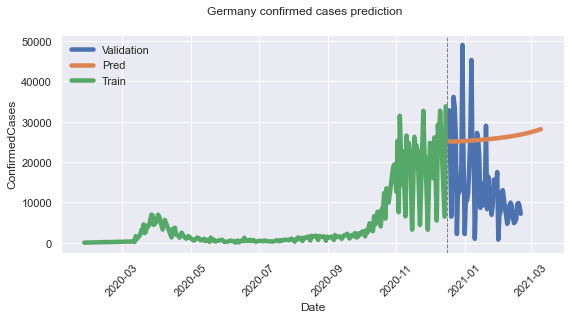

RMSLE : 0.63191  (not normalized)


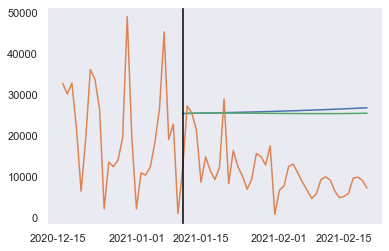

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:16<00:00,  2.67s/it, Loss =0.0624, Lr=0.01]


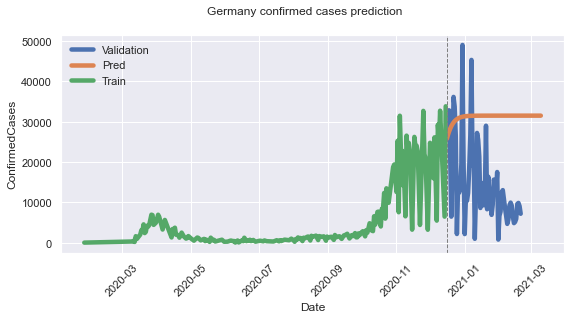

RMSLE : 0.54822  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:16<00:00,  2.71s/it, Loss =0.0206, Lr=0.01]


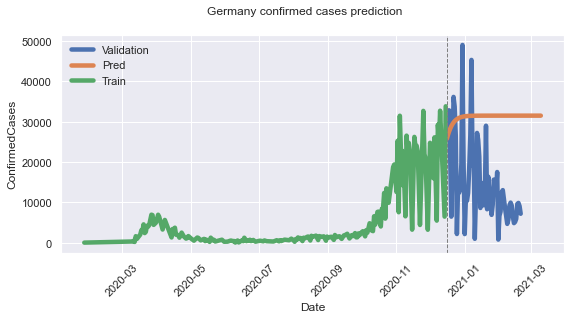

RMSLE : 0.59647  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


 17%|█▋        | 1/6 [00:02<00:11,  2.35s/it, Loss =0.331, Lr=0.01]

tensor(3.3193e+10, grad_fn=<AddBackward0>)



  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7



 17%|█▋        | 1/6 [00:01<00:09,  1.92s/it, Loss =0.639, Lr=0.01]

tensor(84.4898, grad_fn=<AddBackward0>)




  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7




  0%|          | 0/6 [00:01<?, ?it/s, Loss =0.29, Lr=0.01]

 17%|█▋        | 1/6 [00:01<00:09,  1.87s/it, Loss =0.29, Lr=0.01]

 17%|█▋        | 1/6 [00:03<00:09,  1.87s/it, Loss =0.0448, Lr=0.01]

 33%|███▎      | 2/6 [00:03<00:07,  1.91s/it, Loss =0.0448, Lr=0.01]

 33%|███▎      | 2/6 [00:07<00:07,  1.91s/it, Loss =0.0251, Lr=0.01]

 50%|█████     | 3/6 [00:07<00:07,  2.47s/it, Loss =0.0251, Lr=0.01]

 50%|█████     | 3/6 [00:10<00:07,  2.47s/it, Loss =0.0232, Lr=0.01]

 67%|██████▋   | 4/6 [00:10<00:05,  2.60s/it, Loss =0.0232, Lr=0.01]

 67%|██████▋   | 4/6 [00:13<00:05,  2.60s/it, Loss =0.0211, Lr=0.01]

 83%|████████▎ | 5/6 [00:13<00:02,  2.63s/it, Loss =0.0211, Lr=0.01]

 83%|████████▎ | 5/6 [00:15<00:02,  2.63s/it, Loss =0.0198, Lr=0.01]

100%|██████████| 6/6 [00:15<00:00,  2.55s/it, Loss =0.0198, Lr=0.01]


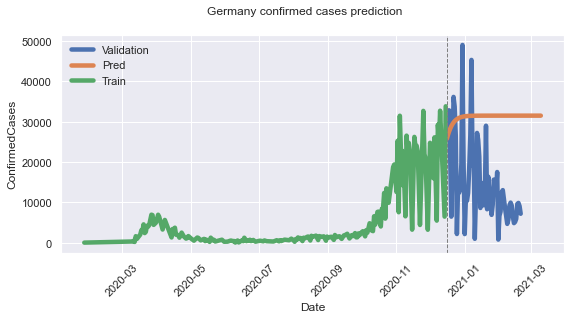

 17%|█▋        | 1/6 [00:21<01:49, 21.82s/it, Loss =0.639, Lr=0.01]

RMSLE : 0.65539  (not normalized)


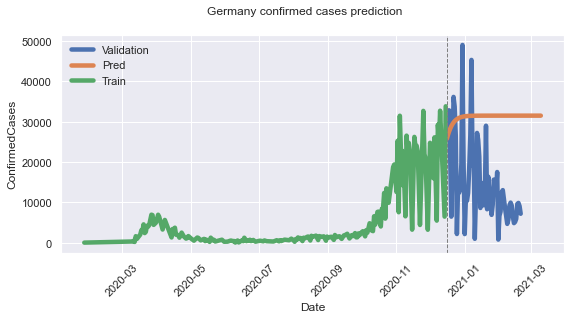

 17%|█▋        | 1/6 [00:28<02:24, 28.92s/it, Loss =0.331, Lr=0.01]

RMSLE : 0.65539  (not normalized)


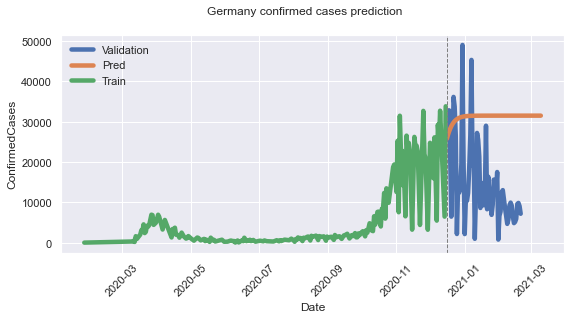

RMSLE : 0.65539  (not normalized)


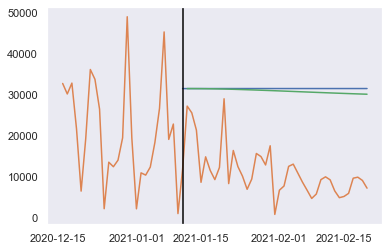

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:02<00:00,  2.96it/s, Loss =0.449, Lr=0.01]


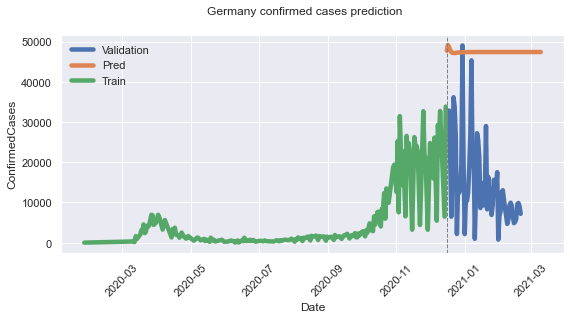

RMSLE : 0.70159  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:13<00:00,  2.17s/it, Loss =0.136, Lr=0.01]


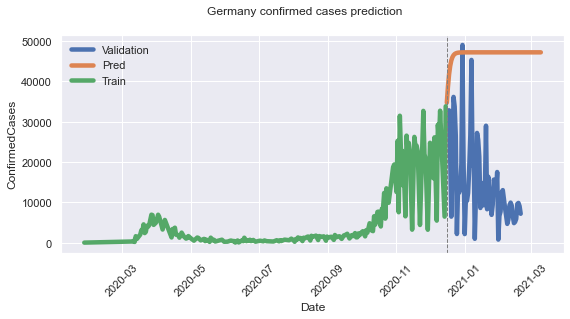

RMSLE : 0.69558  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


 17%|█▋        | 1/6 [00:02<00:10,  2.03s/it, Loss =0.691, Lr=0.01]

tensor(3150.6453, grad_fn=<AddBackward0>)



  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7



100%|██████████| 6/6 [00:13<00:00,  2.23s/it, Loss =0.0202, Lr=0.01]


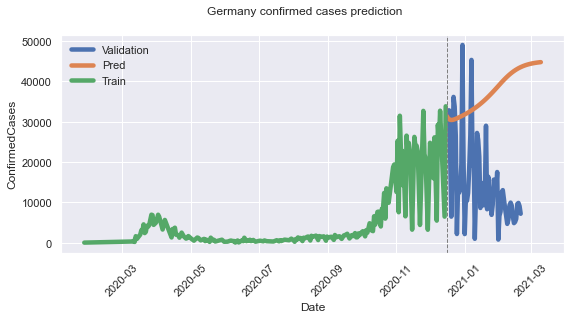

 17%|█▋        | 1/6 [00:18<01:31, 18.36s/it, Loss =0.691, Lr=0.01]

RMSLE : 0.59921  (not normalized)


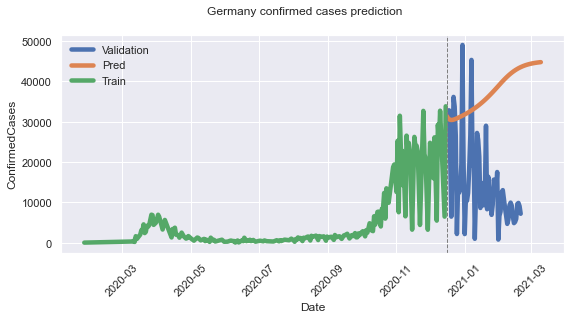

RMSLE : 0.59921  (not normalized)


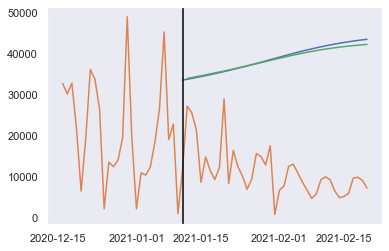

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:15<00:00,  2.54s/it, Loss =0.0202, Lr=0.01]


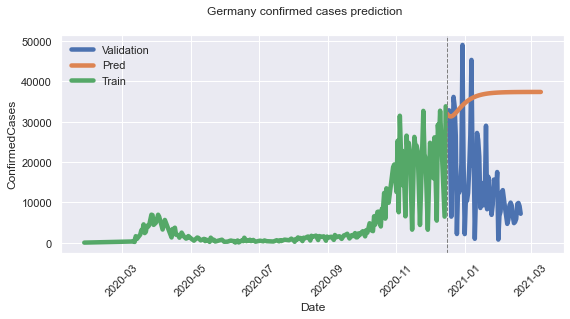

RMSLE : 0.59729  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:13<00:00,  2.23s/it, Loss =0.202, Lr=0.01]


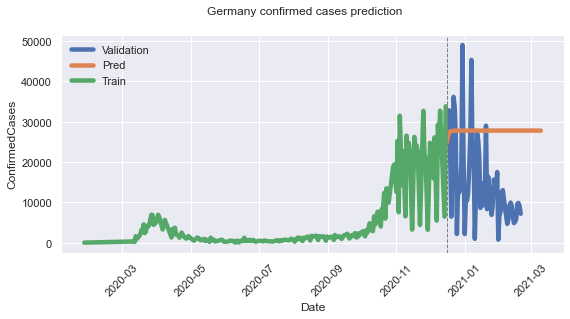

RMSLE : 0.51056  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:13<00:00,  2.20s/it, Loss =0.0486, Lr=0.01]


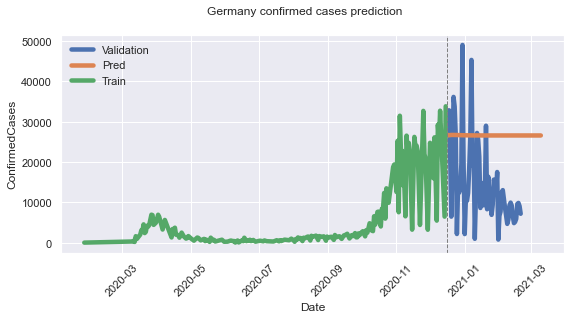

RMSLE : 0.49770  (not normalized)


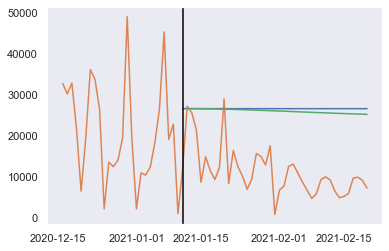

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:10<00:00,  1.71s/it, Loss =0.967, Lr=0.01] 


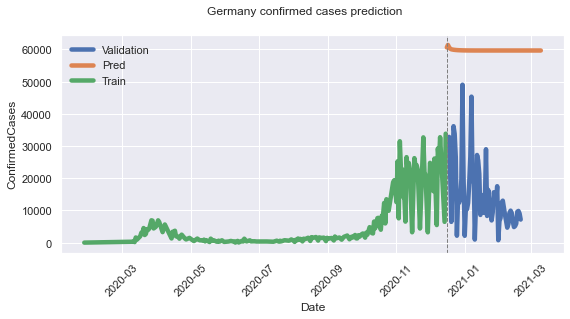

RMSLE : 0.79071  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:12<00:00,  2.07s/it, Loss =0.0261, Lr=0.01]


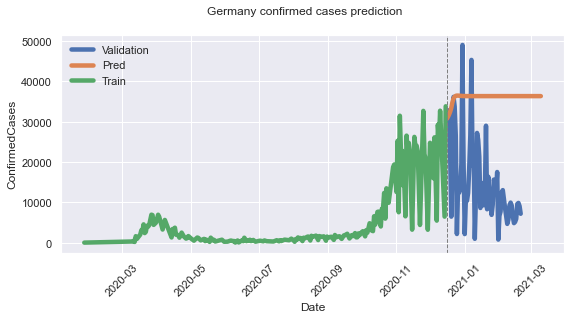

RMSLE : 0.59980  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


 17%|█▋        | 1/6 [00:02<00:10,  2.05s/it, Loss =0.416, Lr=0.01]

tensor(8736.7041, grad_fn=<AddBackward0>)



  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7



 17%|█▋        | 1/6 [00:01<00:09,  1.89s/it, Loss =0.585, Lr=0.01]

tensor(458772.4688, grad_fn=<AddBackward0>)




  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7




  0%|          | 0/6 [00:02<?, ?it/s, Loss =0.264, Lr=0.01]

 17%|█▋        | 1/6 [00:02<00:10,  2.12s/it, Loss =0.264, Lr=0.01]

 17%|█▋        | 1/6 [00:04<00:10,  2.12s/it, Loss =0.0483, Lr=0.01]

 33%|███▎      | 2/6 [00:04<00:08,  2.15s/it, Loss =0.0483, Lr=0.01]

 33%|███▎      | 2/6 [00:06<00:08,  2.15s/it, Loss =0.0237, Lr=0.01]

 50%|█████     | 3/6 [00:06<00:06,  2.12s/it, Loss =0.0237, Lr=0.01]

 50%|█████     | 3/6 [00:08<00:06,  2.12s/it, Loss =0.0205, Lr=0.01]

 67%|██████▋   | 4/6 [00:08<00:04,  2.12s/it, Loss =0.0205, Lr=0.01]

 67%|██████▋   | 4/6 [00:10<00:04,  2.12s/it, Loss =0.0198, Lr=0.01]

 83%|████████▎ | 5/6 [00:10<00:02,  2.12s/it, Loss =0.0198, Lr=0.01]

 83%|████████▎ | 5/6 [00:12<00:02,  2.12s/it, Loss =0.0195, Lr=0.01]

100%|██████████| 6/6 [00:12<00:00,  2.15s/it, Loss =0.0195, Lr=0.01]


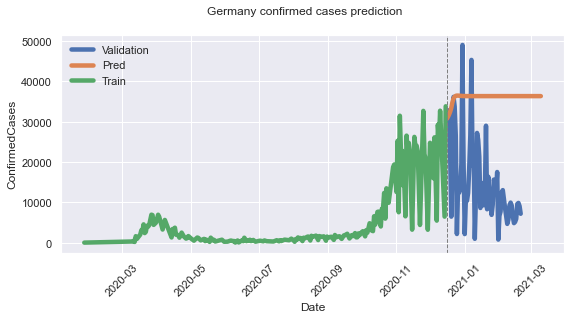

 17%|█▋        | 1/6 [00:19<01:38, 19.62s/it, Loss =0.585, Lr=0.01]

RMSLE : 0.72243  (not normalized)


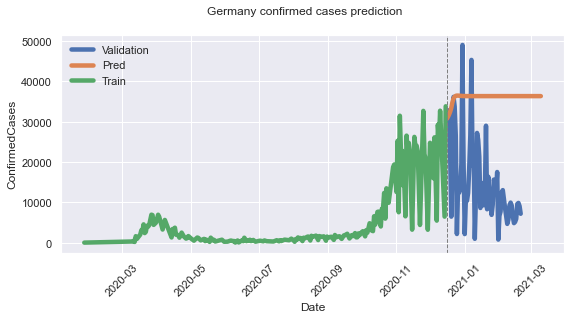

 17%|█▋        | 1/6 [00:26<02:11, 26.27s/it, Loss =0.416, Lr=0.01]

RMSLE : 0.72243  (not normalized)


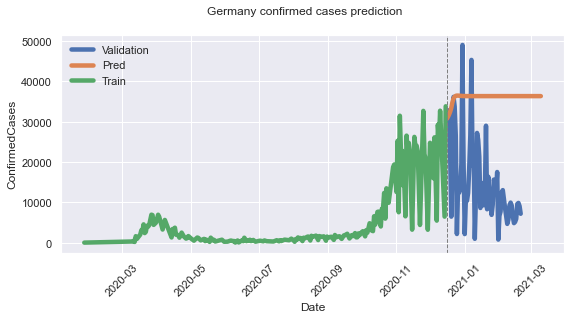

RMSLE : 0.72243  (not normalized)


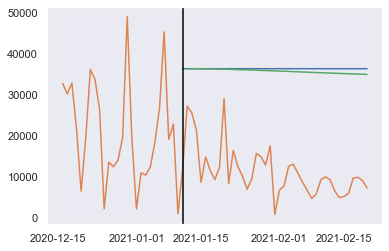

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:13<00:00,  2.18s/it, Loss =0.0216, Lr=0.01]


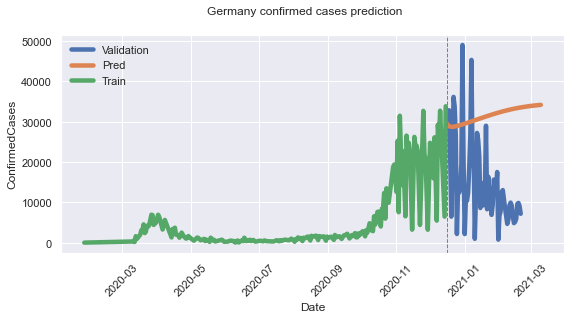

RMSLE : 0.54860  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:12<00:00,  2.07s/it, Loss =0.0199, Lr=0.01]


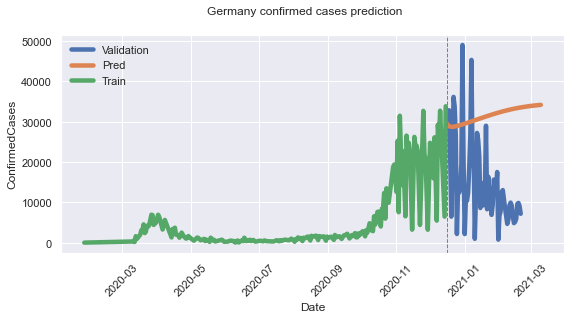

RMSLE : 0.68565  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:13<00:00,  2.25s/it, Loss =0.0191, Lr=0.01]


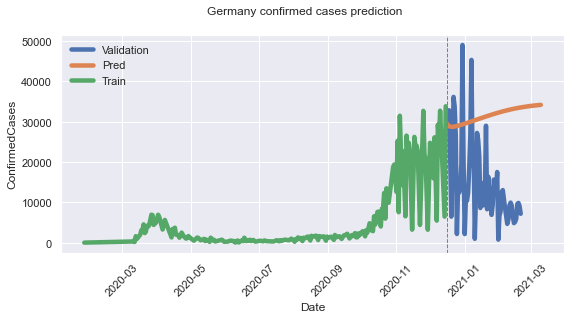

RMSLE : 0.70511  (not normalized)


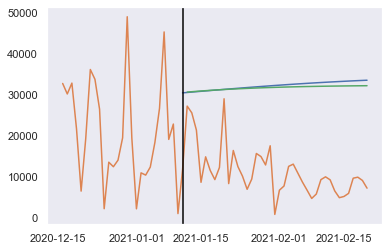

  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


100%|██████████| 6/6 [00:00<00:00,  7.48it/s, Loss =8.75, Lr=0.01] 


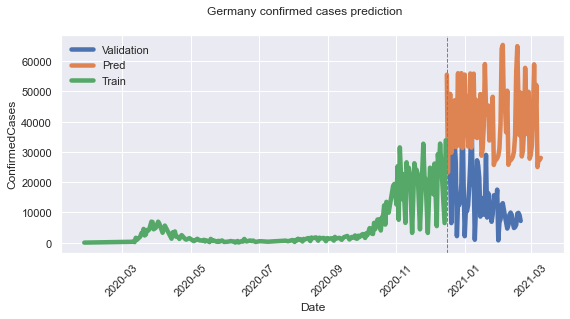

RMSLE : 0.63943  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


 33%|███▎      | 2/6 [00:02<00:06,  1.62s/it, Loss =0.0363, Lr=0.01]

tensor(10.7456, grad_fn=<AddBackward0>)



  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7



 17%|█▋        | 1/6 [00:02<00:10,  2.10s/it, Loss =0.492, Lr=0.01]

tensor(2587.2617, grad_fn=<AddBackward0>)




  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7




  0%|          | 0/6 [00:01<?, ?it/s, Loss =0.381, Lr=0.01]

 17%|█▋        | 1/6 [00:01<00:09,  1.82s/it, Loss =0.381, Lr=0.01]

 17%|█▋        | 1/6 [00:03<00:09,  1.82s/it, Loss =0.11, Lr=0.01] 

 33%|███▎      | 2/6 [00:03<00:07,  1.88s/it, Loss =0.11, Lr=0.01]

 33%|███▎      | 2/6 [00:05<00:07,  1.88s/it, Loss =0.0469, Lr=0.01]

 50%|█████     | 3/6 [00:05<00:05,  1.94s/it, Loss =0.0469, Lr=0.01]

 50%|█████     | 3/6 [00:08<00:05,  1.94s/it, Loss =0.0399, Lr=0.01]

 67%|██████▋   | 4/6 [00:08<00:04,  2.07s/it, Loss =0.0399, Lr=0.01]

 67%|██████▋   | 4/6 [00:10<00:04,  2.07s/it, Loss =0.0331, Lr=0.01]

 83%|████████▎ | 5/6 [00:10<00:02,  2.11s/it, Loss =0.0331, Lr=0.01]

 83%|████████▎ | 5/6 [00:12<00:02,  2.11s/it, Loss =4.96, Lr=0.01]  

100%|██████████| 6/6 [00:12<00:00,  2.11s/it, Loss =4.96, Lr=0.01]


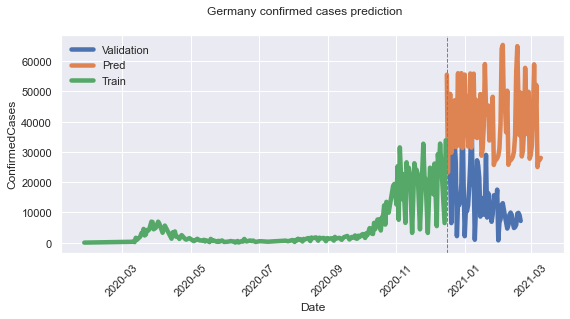

 17%|█▋        | 1/6 [00:19<01:36, 19.38s/it, Loss =0.492, Lr=0.01]

RMSLE : 100000000000.00000  (not normalized)


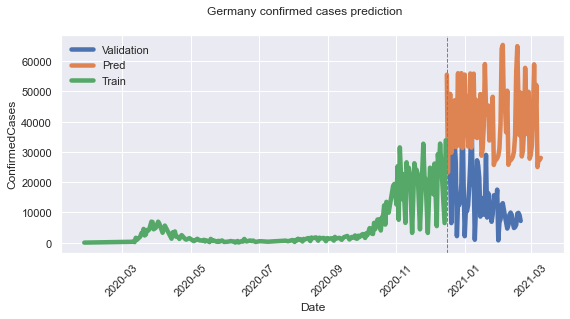

 33%|███▎      | 2/6 [00:25<00:50, 12.65s/it, Loss =0.0363, Lr=0.01]

RMSLE : 100000000000.00000  (not normalized)


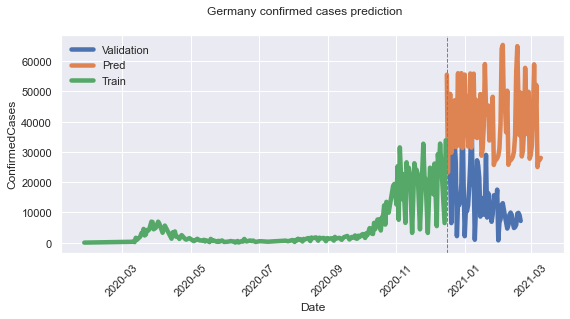

RMSLE : 100000000000.00000  (not normalized)


  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7


 33%|███▎      | 2/6 [00:03<00:07,  1.83s/it, Loss =0.0697, Lr=0.01]

tensor(1149.4202, grad_fn=<AddBackward0>)



  0%|          | 0/6 [00:00<?, ?it/s]

Init LSTM model for Germany, trained up to 2020-12-16 00:00:00, with a Confirmed Cases threshold of 70  and window size of 7



100%|██████████| 6/6 [00:15<00:00,  2.57s/it, Loss =0.0241, Lr=0.01]


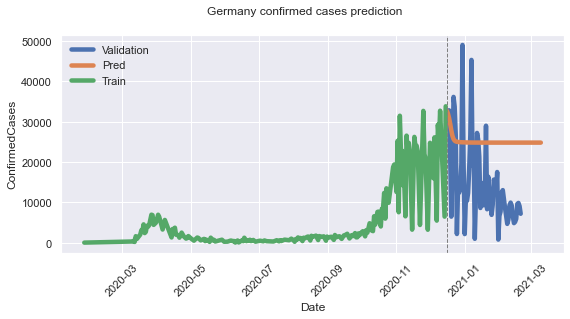

 33%|███▎      | 2/6 [00:21<00:43, 10.82s/it, Loss =0.0697, Lr=0.01]

RMSLE : 0.48218  (not normalized)


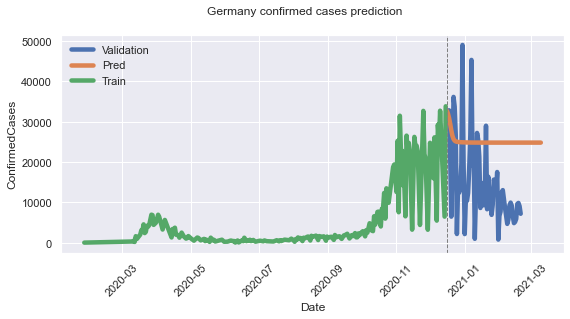

RMSLE : 0.48218  (not normalized)


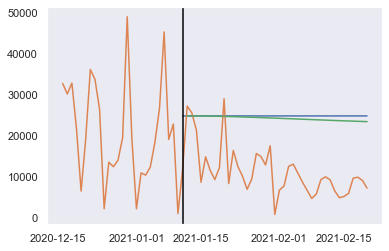

In [927]:
BIAS = SIR_results["I"]
FUTURE_DAYS  = 85
iterations = 3

runs_without_bias, runs_with_bias = [], []

for _ in range(10):
    lstm = LSTM(COUNTRY, TRAIN_UP_TO, FUTURE_DAYS, ThreshDead, TARGET, TYPE, DELAY_START)
    for i in range(iterations):
        results1 = lstm.simulate()
    # Add bias to predictions
    bias_results = add_bias(results1, BIAS)
    runs_with_bias.append(bias_results)

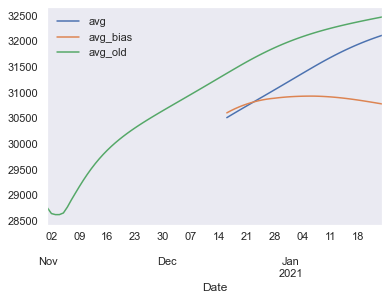

In [928]:
# runs_with_bias = runs_with_bias[0:7]
predictions_with_bias, predictions_without_bias, total_old = [], [], []
for i in range(len(runs_with_bias)):
    predictions_with_bias.append(runs_with_bias[i]["pred"])
    predictions_without_bias.append(runs_with_bias[i]["oldpred"])
    total_old.append(runs_with_bias[i]["total_old_pred"])

average_bias = np.average(predictions_with_bias, axis=0)
average = np.average(predictions_without_bias, axis=0)
average_total = np.average(total_old, axis=0)
x_axis  = [TRAIN_UP_TO + datetime.timedelta(days=x) for x in range(len(average))]

columns=["Date", "avg", "avg_bias", "avg_old"]
df_average = pd.DataFrame(columns=columns)
df_average["avg"] = average
df_average["avg_bias"] = average_bias
df_average["Date"] = x_axis


x_axis2 = [TRAIN_UP_TO - datetime.timedelta(days=x) - datetime.timedelta(days=1) for x in range(len(average_total) - len(average))]
df_temp = pd.DataFrame(columns=columns)
df_temp["Date"] = np.sort(x_axis2)

df_average.index += len(x_axis2)
df_average = pd.concat([df_temp, df_average])
df_average["avg_old"] = average_total
df_average.plot(x="Date", y=columns[1:4])


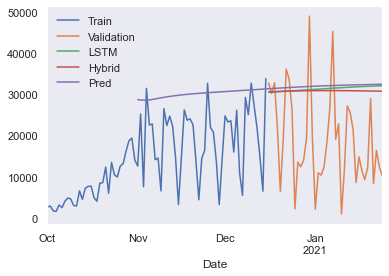

In [929]:
FACTOR = 0
# Create dataframe to plot
results_df = pd.DataFrame(columns=["Date", "Train", "Validation", "LSTM", "Hybrid", "Pred"])
results_df["Date"] = pd.concat([runs_with_bias[0]["trainData"]["Date"], runs_with_bias[0]["valData"]["Date"]])

results_df["Validation"] = runs_with_bias[0]["valData"]["ConfirmedCases"]
results_df["Train"] = runs_with_bias[0]["trainData"]["ConfirmedCases"]

# Set correct dates
# results_df_copy = results_df.copy()
# results_df_copy = results_df_copy.reset_index()
# df_index = results_df_copy[results_df_copy["Date"] == TRAIN_UP_TO].index[0] + days_delay
# df_index_pred = results_df_copy[results_df_copy["Date"] == DELAY_START].index[0] 

results_df = results_df.reset_index()
results_df = results_df[results_df["Date"] <= df_average["Date"].values[-1]]
results_df["LSTM"].iloc[-len(df_average["avg"]):] = df_average["avg"]
results_df["Hybrid"].iloc[-len(df_average["avg_bias"]):] = df_average["avg_bias"]
results_df["Pred"].iloc[-len(df_average["avg_old"]):] = df_average["avg_old"]
# results_df["mean"] = df_average["mean"]
# results_df["std"] = df_average["std"]
# results_df["mean_bias"] = df_average["mean_bias"]
# results_df["std_bias"] = df_average["std_bias"]

results_df_section = results_df.query("Date>='2020-10-01'")
results_df_section.plot(x="Date", y=["Train", "Validation", 'LSTM', 'Hybrid', 'Pred'])
results_df.to_pickle("hybrid_23-02" + COUNTRY + '.p')
